In [8]:
# ============================================
# Import semua library yang dibutuhkan
# ============================================

# Library dasar untuk data manipulation dan visualisasi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Model-model Machine Learning yang akan di-train
from sklearn.linear_model import LogisticRegression  # Model linear sederhana untuk baseline
from sklearn.tree import DecisionTreeClassifier      # Model tree-based sederhana
from sklearn.ensemble import RandomForestClassifier  # Ensemble dari multiple decision trees
from xgboost import XGBClassifier                    # Gradient boosting - biasanya paling akurat
from lightgbm import LGBMClassifier                  # Gradient boosting versi lebih cepat

# Library untuk menangani class imbalance
from imblearn.over_sampling import SMOTE  # Synthetic Minority Over-sampling Technique

# Metrics untuk evaluasi performa model
from sklearn.metrics import (
    accuracy_score,      # Persentase prediksi yang benar
    precision_score,     # Dari prediksi positif, berapa yang benar
    recall_score,        # Dari kasus positif aktual, berapa yang terdeteksi
    f1_score,            # Harmonic mean dari precision dan recall
    roc_auc_score,       # Area under ROC curve - metric utama
    classification_report,
    confusion_matrix
)

import joblib  # Untuk save dan load model
import warnings
warnings.filterwarnings('ignore')  # Mematikan warning agar output lebih bersih

print

<function print(*args, sep=' ', end='\n', file=None, flush=False)>

In [9]:
# ============================================
# Load data hasil preprocessing
# ============================================

# Load training set (80% dari total data)
X_train = pd.read_csv(r'D:\churn-app\data\processed\X_train.csv')  # Features untuk training
y_train = pd.read_csv(r'D:\churn-app\data\processed\y_train.csv').values.ravel()  # Target training, ravel() mengubah ke 1D array

# Load testing set (20% dari total data untuk evaluasi)
X_test = pd.read_csv(r'D:\churn-app\data\processed\X_test.csv')  # Features untuk testing
y_test = pd.read_csv(r'D:\churn-app\data\processed\y_test.csv').values.ravel()  # Target testing

# Verifikasi dimensi data
print(f"X_train shape: {X_train.shape}")  # Format: (jumlah_samples, jumlah_features)
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Check distribusi churn rate
print(f"\nChurn rate in train: {y_train.mean():.2%}")  # Mean dari binary (0,1) = persentase kelas 1
print(f"Churn rate in test: {y_test.mean():.2%}")

X_train shape: (5634, 35)
X_test shape: (1409, 35)
y_train shape: (5634,)
y_test shape: (1409,)

Churn rate in train: 26.54%
Churn rate in test: 26.54%


In [11]:
# ============================================
# Menangani class imbalance menggunakan SMOTE
# ============================================

# Problem: Dataset imbalanced (~26% churn, ~74% no churn)
# Solusi: SMOTE membuat synthetic samples dari minority class

# Distribusi sebelum SMOTE
print("Before SMOTE:")
print(f"No Churn (0): {(y_train == 0).sum()}")  # Jumlah kelas 0 (no churn)
print(f"Churn (1): {(y_train == 1).sum()}")     # Jumlah kelas 1 (churn)
print(f"Ratio: {(y_train == 1).sum() / (y_train == 0).sum():.2f}")  # Rasio minority/majority

# Apply SMOTE untuk oversampling minority class
smote = SMOTE(random_state=42)  # random_state untuk reproducibility
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Distribusi setelah SMOTE
print("\nAfter SMOTE:")
print(f"No Churn (0): {(y_train_balanced == 0).sum()}")
print(f"Churn (1): {(y_train_balanced == 1).sum()}")
print(f"Ratio: {(y_train_balanced == 1).sum() / (y_train_balanced == 0).sum():.2f}")  # Seharusnya 1.00 (balanced)

print(f"\n Class imbalance handled - data now balanced")

Before SMOTE:
No Churn (0): 4139
Churn (1): 1495
Ratio: 0.36

After SMOTE:
No Churn (0): 4139
Churn (1): 4139
Ratio: 1.00

 Class imbalance handled - data now balanced


In [12]:
# ============================================
# Inisialisasi dictionary untuk menyimpan hasil
# ============================================

# Dictionary ini akan menyimpan semua model dan metrics-nya
results = {}

print("Training multiple models...\n")
print("="*60)

Training multiple models...



In [13]:
# ============================================
# MODEL 1: LOGISTIC REGRESSION (BASELINE)
# ============================================

# Logistic Regression = model linear sederhana
# Digunakan sebagai baseline - model lain harus beat ini

print("1. Training Logistic Regression...")

# Initialize model
lr = LogisticRegression(
    random_state=42,  # Seed untuk reproducibility
    max_iter=1000     # Maximum iterations untuk convergence
)

# Training: model belajar pattern dari data
lr.fit(X_train_balanced, y_train_balanced)

# Prediction pada test set
y_pred_lr = lr.predict(X_test)  # Binary prediction (0 atau 1)
y_proba_lr = lr.predict_proba(X_test)[:, 1]  # Probability untuk class 1 (churn)

# Simpan model dan metrics
results['Logistic Regression'] = {
    'model': lr,
    'accuracy': accuracy_score(y_test, y_pred_lr),
    'precision': precision_score(y_test, y_pred_lr),
    'recall': recall_score(y_test, y_pred_lr),
    'f1': f1_score(y_test, y_pred_lr),
    'roc_auc': roc_auc_score(y_test, y_proba_lr)  # Metric utama
}

print(f"   ROC-AUC: {results['Logistic Regression']['roc_auc']:.4f}")
print(f"   Accuracy: {results['Logistic Regression']['accuracy']:.4f}")
print("   ✅ Done!")

1. Training Logistic Regression...
   ROC-AUC: 0.8315
   Accuracy: 0.7630
   ✅ Done!


In [14]:
# ============================================
# MODEL 2: DECISION TREE
# ============================================

# Decision Tree = model berbasis rules (if-else)
# Pro: Interpretable, mudah dipahami
# Con: Prone to overfitting

print("\n2. Training Decision Tree...")

# Initialize model
dt = DecisionTreeClassifier(
    max_depth=10,     # Membatasi kedalaman tree untuk mengurangi overfitting
    random_state=42
)

# Training
dt.fit(X_train_balanced, y_train_balanced)

# Prediction
y_pred_dt = dt.predict(X_test)
y_proba_dt = dt.predict_proba(X_test)[:, 1]

# Simpan hasil
results['Decision Tree'] = {
    'model': dt,
    'accuracy': accuracy_score(y_test, y_pred_dt),
    'precision': precision_score(y_test, y_pred_dt),
    'recall': recall_score(y_test, y_pred_dt),
    'f1': f1_score(y_test, y_pred_dt),
    'roc_auc': roc_auc_score(y_test, y_proba_dt)
}

print(f"   ROC-AUC: {results['Decision Tree']['roc_auc']:.4f}")
print(f"   Accuracy: {results['Decision Tree']['accuracy']:.4f}")
print("   ✅ Done!")


2. Training Decision Tree...
   ROC-AUC: 0.7632
   Accuracy: 0.7417
   ✅ Done!


In [15]:
# ============================================
# MODEL 3: RANDOM FOREST
# ============================================

# Random Forest = Ensemble dari multiple decision trees
# Setiap tree di-train pada random subset data dan features
# Prediction final = voting/averaging dari semua trees
# Pro: Lebih robust, reduce overfitting
# Con: Lebih lambat, less interpretable

print("\n3. Training Random Forest...")

# Initialize model
rf = RandomForestClassifier(
    n_estimators=100,  # Jumlah trees yang akan dibuat
    max_depth=10,      # Max depth per tree
    random_state=42,
    n_jobs=-1          # Parallel processing menggunakan semua CPU cores
)

# Training - akan memakan waktu lebih lama karena train 100 trees
rf.fit(X_train_balanced, y_train_balanced)

# Prediction
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

# Simpan hasil
results['Random Forest'] = {
    'model': rf,
    'accuracy': accuracy_score(y_test, y_pred_rf),
    'precision': precision_score(y_test, y_pred_rf),
    'recall': recall_score(y_test, y_pred_rf),
    'f1': f1_score(y_test, y_pred_rf),
    'roc_auc': roc_auc_score(y_test, y_proba_rf)
}

print(f"   ROC-AUC: {results['Random Forest']['roc_auc']:.4f}")
print(f"   Accuracy: {results['Random Forest']['accuracy']:.4f}")
print("   ✅ Done!")


3. Training Random Forest...
   ROC-AUC: 0.8381
   Accuracy: 0.7566
   ✅ Done!


In [16]:
# ============================================
# MODEL 4: XGBOOST
# ============================================

# XGBoost = Extreme Gradient Boosting
# Build trees secara sequential - setiap tree memperbaiki error dari tree sebelumnya
# Pro: Biasanya memberikan accuracy tertinggi, built-in regularization
# Con: Hyperparameter tuning lebih complex, training lebih lama

print("\n4. Training XGBoost...")

# Initialize model
xgb = XGBClassifier(
    n_estimators=100,      # Jumlah boosting rounds
    max_depth=5,           # Depth per tree (lebih shallow untuk reduce overfitting)
    learning_rate=0.1,     # Step size shrinkage (0.1 = conservative)
    random_state=42,
    eval_metric='logloss'  # Metric untuk internal evaluation
)

# Training
xgb.fit(X_train_balanced, y_train_balanced)

# Prediction
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

# Simpan hasil
results['XGBoost'] = {
    'model': xgb,
    'accuracy': accuracy_score(y_test, y_pred_xgb),
    'precision': precision_score(y_test, y_pred_xgb),
    'recall': recall_score(y_test, y_pred_xgb),
    'f1': f1_score(y_test, y_pred_xgb),
    'roc_auc': roc_auc_score(y_test, y_proba_xgb)
}

print(f"   ROC-AUC: {results['XGBoost']['roc_auc']:.4f}")
print(f"   Accuracy: {results['XGBoost']['accuracy']:.4f}")
print("   ✅ Done!")


4. Training XGBoost...
   ROC-AUC: 0.8342
   Accuracy: 0.7622
   ✅ Done!


In [17]:
# ============================================
# MODEL 5: LIGHTGBM
# ============================================

# LightGBM = Light Gradient Boosting Machine (Microsoft)
# Similar dengan XGBoost tapi menggunakan leaf-wise tree growth (vs level-wise)
# Pro: Training lebih cepat, efficient memory usage, handle categorical features
# Con: Prone to overfitting pada small datasets

print("\n5. Training LightGBM...")

# Initialize model
lgbm = LGBMClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    verbose=-1  # Mematikan verbose logging
)

# Training
lgbm.fit(X_train_balanced, y_train_balanced)

# Prediction
y_pred_lgbm = lgbm.predict(X_test)
y_proba_lgbm = lgbm.predict_proba(X_test)[:, 1]

# Simpan hasil
results['LightGBM'] = {
    'model': lgbm,
    'accuracy': accuracy_score(y_test, y_pred_lgbm),
    'precision': precision_score(y_test, y_pred_lgbm),
    'recall': recall_score(y_test, y_pred_lgbm),
    'f1': f1_score(y_test, y_pred_lgbm),
    'roc_auc': roc_auc_score(y_test, y_proba_lgbm)
}

print(f"   ROC-AUC: {results['LightGBM']['roc_auc']:.4f}")
print(f"   Accuracy: {results['LightGBM']['accuracy']:.4f}")
print("   ✅ Done!")


5. Training LightGBM...
   ROC-AUC: 0.8312
   Accuracy: 0.7630
   ✅ Done!


In [18]:
# ============================================
# Membandingkan performa semua model
# ============================================

# Membuat DataFrame untuk comparison
comparison = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results],
    'Precision': [results[m]['precision'] for m in results],
    'Recall': [results[m]['recall'] for m in results],
    'F1-Score': [results[m]['f1'] for m in results],
    'ROC-AUC': [results[m]['roc_auc'] for m in results]
})

# Sort berdasarkan ROC-AUC (descending)
comparison = comparison.sort_values('ROC-AUC', ascending=False)

# Print comparison table
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
print(comparison.to_string(index=False))
print("="*60)

# Identifikasi model terbaik (ROC-AUC tertinggi)
best_model_name = comparison.iloc[0]['Model']
print(f"\n🏆 Best Model: {best_model_name}")
print(f"   ROC-AUC: {comparison.iloc[0]['ROC-AUC']:.4f}")


MODEL COMPARISON
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
      Random Forest  0.756565   0.528972 0.756684  0.622662 0.838145
            XGBoost  0.762243   0.539715 0.708556  0.612717 0.834234
Logistic Regression  0.762952   0.541841 0.692513  0.607981 0.831509
           LightGBM  0.762952   0.541322 0.700535  0.610723 0.831225
      Decision Tree  0.741661   0.509294 0.732620  0.600877 0.763246

🏆 Best Model: Random Forest
   ROC-AUC: 0.8381


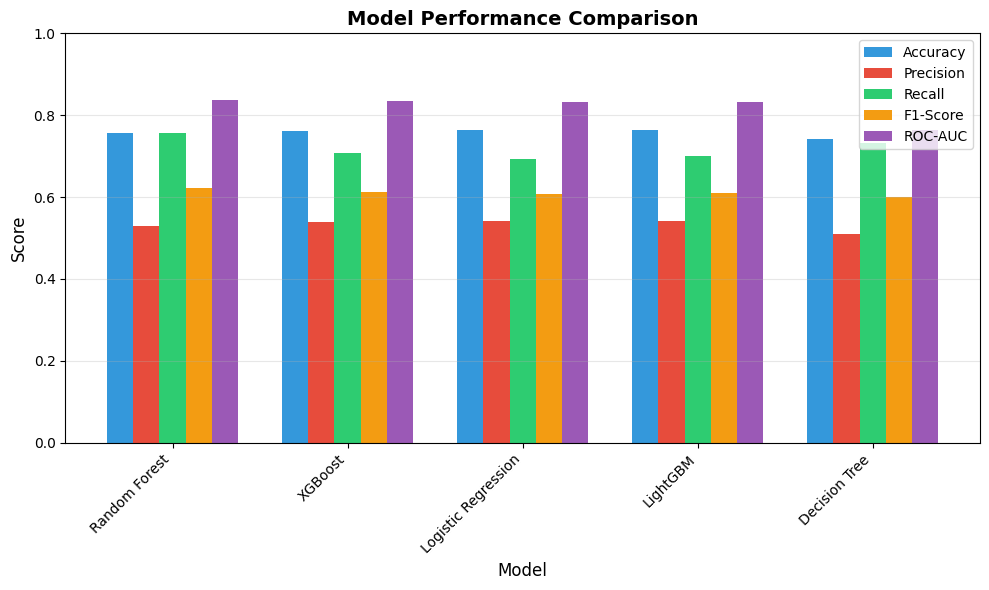

In [19]:
# ============================================
# Visualisasi perbandingan model (bar chart)
# ============================================

fig, ax = plt.subplots(figsize=(10, 6))

# Setup bar positions
x = np.arange(len(comparison))
width = 0.15

# Metrics yang akan di-plot
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']

# Create bars untuk setiap metric
for i, metric in enumerate(metrics):
    ax.bar(x + i*width, comparison[metric], width, label=metric, color=colors[i])

# Styling
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 2)
ax.set_xticklabels(comparison['Model'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig(r'D:\churn-app\outputs\figures\model_comparison.png', dpi=150)
plt.show()

In [20]:
# ============================================
# Menyimpan model terbaik untuk production
# ============================================

# Retrieve model object dari model terbaik
best_model = results[best_model_name]['model']

# Define path untuk save model
model_path = r'D:\churn-app\models\churn_model.pkl'

# Serialize dan save model menggunakan joblib
joblib.dump(best_model, model_path)

print(f"✅ Best model saved: {model_path}")
print(f"   Model: {best_model_name}")
print(f"   ROC-AUC: {results[best_model_name]['roc_auc']:.4f}")

✅ Best model saved: D:\churn-app\models\churn_model.pkl
   Model: Random Forest
   ROC-AUC: 0.8381


In [21]:
# ============================================
# Testing prediksi model (sanity check)
# ============================================

# Ambil 5 sample dari test set
sample = X_test.iloc[0:5]

# Generate predictions
predictions = best_model.predict(sample)  # Binary (0 atau 1)
probabilities = best_model.predict_proba(sample)[:, 1]  # Probability (0.0 - 1.0)

# Buat DataFrame untuk comparison
test_df = pd.DataFrame({
    'Actual': y_test[0:5],
    'Predicted': predictions,
    'Churn_Probability': probabilities
})

print("\nSample Predictions:")
print(test_df)
print("\n✅ Model working correctly")
print("\nInterpretation:")
print("- Actual: Ground truth dari test set")
print("- Predicted: Model prediction (0=no churn, 1=churn)")
print("- Churn_Probability: Confidence score (>0.5 = predict churn)")


Sample Predictions:
   Actual  Predicted  Churn_Probability
0       0          0           0.030498
1       0          1           0.859377
2       0          0           0.129183
3       0          1           0.546801
4       0          0           0.022811

✅ Model working correctly

Interpretation:
- Actual: Ground truth dari test set
- Predicted: Model prediction (0=no churn, 1=churn)
- Churn_Probability: Confidence score (>0.5 = predict churn)
